#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. 

In [ ]:
import numpy as np
from tqdm import tqdm
import sys
from gensim.models import FastText
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH_TO_TRAIN_DATA = '/content/drive/MyDrive/train.csv'

In [ ]:
import pandas as pd

df = pd.read_csv(PATH_TO_TRAIN_DATA)
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 


Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [ ]:
import string
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
nltk.download('punkt')
sum_noise = list(string.punctuation)

from nltk.tokenize import word_tokenize

def process_text(text):
    return [word for word in word_tokenize(text.lower()) if word not in sum_noise]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df)

Обучим логистическую регрессию на TF-IDF векторах текстов.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression

In [ ]:
df_train['com'] = df_train['negative'] + ' ' + df_train['positive']
df_test['com'] = df_test['negative'] + ' ' + df_test['positive']
linreg = LinearRegression()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
tfidf_vec = TfidfVectorizer()
X = tfidf_vec.fit_transform(df_train['com'])

In [ ]:
linreg.fit(X, df_train['score'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Обучим логистическую регрессию на усредненных Word2Vec векторах. 

In [ ]:
import gensim

In [ ]:
df_train['com'] = df_train['com'].apply(process_text)
df_test['com'] = df_test['com'].apply(process_text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
sizes = [100, 200, 300, 400, 500]

In [ ]:
result_1 = []
for size in tqdm(sizes):
  model =  gensim.models.word2vec.Word2Vec(df_train['com'], size = size, min_count=1)
  w2e = []
  for com in (df_train['com']):
    emb = np.array([])
    i = 0
    for word in com:
      if word in model.wv.vocab:
        i+=1
        if emb.size:
          emb = emb+model.wv[word]
        elif not emb.size:
          emb = model.wv[word]
    emb = emb/i
    if emb.size == 0:
      emb = np.zeros(size)
    
    w2e.append(emb)

  linreg.fit(w2e, df_train['score'])

  w2et = []
  for com in (df_test['com']):
    emb = np.array([])
    i = 0
    for word in com:
      if word in model.wv.vocab:
        i+=1
        if emb.size:
          emb = emb+model.wv[word]
        elif not emb.size:
          emb = model.wv[word]
    emb = emb/i
    if emb.size == 0:
      emb = np.zeros(size)
    w2et.append(emb)

  y_pred = linreg.predict(w2et)
  result_1.append(mean_absolute_error(y_pred, df_test['score']))



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:20<01:22, 20.63s/it]

 40%|████      | 2/5 [00:44<01:04, 21.53s/it]

 60%|██████    | 3/5 [01:11<00:46, 23.11s/it]

 80%|████████  | 4/5 [01:41<00:25, 25.17s/it]

100%|██████████| 5/5 [02:14<00:00, 26.99s/it]


Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь воспользуемся другой концепцией и перевзвесим слова при получении итогового эмбеддинга текста. В качестве весов используем IDF (Inverse document frequency)

In [ ]:
idf = tfidf_vec.idf_
idf_dickt = (dict(zip(tfidf_vec.get_feature_names(), idf)))

#https://stackoverflow.com/questions/23792781/tf-idf-feature-weights-using-sklearn-feature-extraction-text-tfidfvectorizer

In [ ]:
result_2 = []
for size in tqdm(sizes):
  model =  gensim.models.word2vec.Word2Vec(df_train['com'], size = size, min_count=1)
  w2e = []
  for com in (df_train['com']):
    emb = np.array([])
    i = 0
    for word in com:
      if word in model.wv.vocab:
        i +=1
        try:
          weight = idf_dickt[word]
        except:
          weight = 1
        if emb.size:
          emb = emb+(model.wv[word]*weight)
        elif not emb.size:
          emb = model.wv[word]*weight
    emb = emb/i
    if emb.size == 0:
      emb = np.zeros(size)
    w2e.append(emb)

  linreg.fit(w2e, df_train['score'])

  w2et = []
  for com in (df_test['com']):
    emb = np.array([])
    i = 0
    for word in com:
      if word in model.wv.vocab:
        i +=1
        try:
          weight = idf_dickt[word]
        except:
          weight = 1
        if emb.size:
          emb = emb+(model.wv[word]*weight)
        elif not emb.size:
          emb = model.wv[word]*weight
    emb = emb/i
    if emb.size == 0:
      emb = np.zeros(size)
    w2et.append(emb)

  y_pred = linreg.predict(w2et)
  result_2.append(mean_absolute_error(y_pred, df_test['score']))



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:24<01:37, 24.40s/it]

 40%|████      | 2/5 [00:51<01:15, 25.21s/it]

 60%|██████    | 3/5 [01:22<00:54, 27.00s/it]

 80%|████████  | 4/5 [01:56<00:29, 29.02s/it]

100%|██████████| 5/5 [02:34<00:00, 30.82s/it]


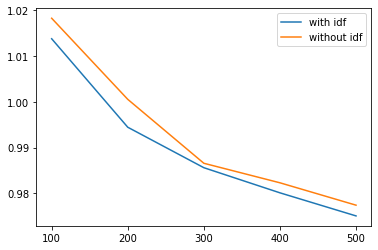

In [ ]:
plt.plot(sizes, result_2, label='with idf')
plt.plot(sizes, result_1, label = 'without idf')
plt.xticks(sizes)
plt.legend()
plt.show()

Ну они падают с увеличением размерности вектора примерно одинаково. Есть соображение о том, что нормирование на веса может давать лучший результат, так как некоторые значимые для этого документа слова будут иметь большой вес и финальный эмбеддинг предложения будет ближе к этому значимому слову. И наоборот менее значимые, частые слова не будут вносить столько импакта


Теперь обучим логистическую регрессию на любых других эмбеддингах размерности 300 и сравним качество с Word2Vec.

In [ ]:
model = FastText(sentences=df_train['com'], size = 300, min_count=1)
result_3 = []
w2e = []
for com in (df_train['com']):
  emb = np.array([])
  i = 0
  for word in com:
    if word in model.wv.vocab:
      i+=1
      if emb.size:
        emb = emb+model.wv[word]
      elif not emb.size:
        emb = model.wv[word]
  emb = emb/i
  if emb.size == 0:
    emb = np.zeros(300)
  
  w2e.append(emb)

linreg.fit(w2e, df_train['score'])

w2et = []
for com in (df_test['com']):
  emb = np.array([])
  i = 0
  for word in com:
    if word in model.wv.vocab:
      i+=1
      if emb.size:
        emb = emb+model.wv[word]
      elif not emb.size:
        emb = model.wv[word]
  emb = emb/i
  if emb.size == 0:
    emb = np.zeros(300)
  w2et.append(emb)

y_pred = linreg.predict(w2et)
result_3.append(mean_absolute_error(y_pred, df_test['score']))

print(result_1[2], result_3[0])

0.9866001466527148 0.9922500766119188


ну различия не особо большие, хотя по итогу ворд2век будет получше
по хорошему, фасттекст должен лучше выхватывать опечатки и редкие слова и быть круче, но на словах он Лев Толстой, как говорится

Теперь воспользуемся более продвинутыми методами обработки текстовых данных. Обучим RNN/Transformer для предсказания пользовательской оценки. 

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

In [ ]:

df['negative'] = df['negative'].apply(process_text)
df['positive'] = df['positive'].apply(process_text)

df_train['com'] = df_train['com'].apply(process_text)
df_test['com'] = df_test['com'].apply(process_text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
WORDS = set()
for sent in list(df['positive']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(df['negative']):
    for w in sent:
        WORDS.add(w)

In [ ]:
int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [ ]:
MAX_LEN = max(max(df['positive'].apply(len)), max(df['negative'].apply(len)))
#MEAN_LEN = max(np.quantile(df['positive'].apply(len), 0.95), np.quantile(df['negative'].apply(len), 0.95))
mean_len = int(max(np.quantile(df_train['com'].apply(len), 0.95), np.quantile(df_test['com'].apply(len), 0.95)))

In [ ]:
MAX_LEN, mean_len

(399, 103)

In [ ]:
df_test.index= np.arange(len(df_test))

In [ ]:
df_train.index = np.arange(len(df_train))

In [ ]:
from torch.nn.utils.rnn import pad_sequence

train_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:mean_len]) for seq in df_train['com']], 
                           batch_first=True).tolist()
test_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:mean_len]) for seq in df_test['com']], 
                           batch_first=True).tolist() 

In [ ]:

leng_t = []
for com in df_train['com']:
  leng_t.append(len(com))

leng_ts = []
for com in df_test['com']:
  leng_ts.append(len(com))

df_train['enc'] = train_pos_pad
df_train['len'] = leng_t

df_test['enc']= test_pos_pad
df_test['len'] = leng_ts

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [ ]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
      self.x = df['enc']
      self.y = df['score']
      self.l = df['len']

      

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx]), self.y[idx], self.l[idx]

In [ ]:
BATCH_SIZE = 1

train_dataset = ReviewsDataset(df_train)
test_dataset = ReviewsDataset(df_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
#https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
class LSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size): 
        super().__init__()
        #self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, l):
        x = self.word_embeddings(x)
        x = self.dropout(x)
        lstmout, (ht, ct) = self.lstm(x)
        x = self.hidden2tag(ht[-1])
        return x


In [ ]:

def train(model,train_dataloader,test_dataloader,epochs,optimizer):
    for i in range(epochs):
        model.train().to(device)
        sl = 0.0
        cnt = 0
        with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
          for x,y,l in (train_dataloader):

            x = x.long().to(device)
            y = y.float().to(device)
            l = l.to(device)
            
            y_pred = model(x,l).to(device)
            optimizer.zero_grad()

            loss = F.mse_loss(y_pred, y.unsqueeze(-1))
            loss.backward()
            optimizer.step()

            sl += mean_absolute_error(y_pred.cpu().detach().numpy(), y.unsqueeze(-1).cpu().numpy())
            cnt += y.shape[0]
            
            
            prbar.set_description(f"Losses: {sl/cnt}")
            prbar.update(1)


def model_eval(model,val_dataloader):
    model.eval().to(device)
    cnt = 0
    sl = 0.0
    with tqdm(total=len(val_dataloader), file=sys.stdout) as prbar:
      for x,y,l in val_dataloader:
        x = x.long().to(device)
        y = y.long().to(device)
        l = l.to(device)

        y_pred = model(x,l).to(device)
        
        sl += mean_absolute_error(y_hat.cpu().detach().numpy(), y.unsqueeze(-1).cpu().numpy())
        cnt += y.shape[0]

        
        prbar.set_description(f"Losses: {sl/cnt}")
        prbar.update(1)
    return (sl/cnt)


In [ ]:
model = LSTM(300, 128, len(WORDS))
params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(params, 0.001)
epochs = 1
device = 'cuda:0'

In [ ]:
train(model,train_dataloader,test_dataloader,epochs,optimizer)

Losses: 0.9631611318111419:  33%|███▎      | 25000/75000 [01:50<03:40, 226.86it/s]
0.9631611318111419 0.8881638397280375


In [ ]:
acc_val = model_eval(model, test_dataloader)

In [ ]:
print ('качество на тестовой выборке = ', acc_val)

качество на тестовой выборке =  0.9631611318111419
